In [6]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from inspect import signature
import math
import numpy as np
import theano
import theano.tensor as T
import math
from scipy.stats import norm

#%matplotlib inline
%reload_ext autoreload
%autoreload 1
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10,10)
plt.ioff()


In [18]:
class RWM(object):
    """
    This class does MH simulation, here Q(x,y)= f(y|x) ~ N(x,\epsilon),
    This can simluate from multivariate distribution

    """

    def __init__(self, fn, no_of_iteration, start, scaling_variance=1., *sigma):
        self.f = fn
        
        start = [start]
        self.start = start
        if not sigma:
            self.sigma = np.identity(len(start))
        self.sigma = scaling_variance*self.sigma

        self.max = no_of_iteration
        self.dim = len(signature(fn).parameters)

    def __iter__(self):

        self.x = self.start
        #self.x = [0] * self.dim
        self.index = 0
        return self

    def __next__(self):

        self.index = self.index + 1
        if self.index > self.max:
            raise StopIteration

        y = multivariate_normal.rvs(self.x, self.sigma)
        if self.dim == 1:
            y = [y]
        acceptance_prob = min(1., self.f(*y) / self.f(*self.x))

        if acceptance_prob <0:
            acceptance_prob = 0

        if np.random.binomial(n=1, p=acceptance_prob) == 1:
            self.x = y
        return self.x[:self.dim]

    def sample(self, n):

        self.__new_sample = [n for n in self]
        return self.__new_sample


In [10]:
# This only works with 1D data
class Variational_inference(object):

    def __init__(self,fn, mu_init, var_init, learning_rate, no_of_sample,no_of_epochs):

        self.f = fn
        self.mu_init = mu_init
        self.var_init = var_init
        self.learning_rate = learning_rate
        self.n = no_of_sample
        self.epoch = no_of_epochs


    def grad(self, mu, var):

        w = T.vector('w')
        x = T.scalar('x')
        log_density = -T.log(T.sqrt(2*math.pi*w[1])) - ((x-w[0])**2)/(2*w[1])
        log_density_grad = T.grad(log_density, w)

        sum =0
        for i in range(self.n):
            sample = mu+ var**.5* np.random.randn()
            sum =sum+np.log(self.f(sample))*log_density_grad.eval({w:[mu, var],x:sample})

        mc_avg = sum/self.n

        mu_grad = -mc_avg[0]
        var_grad = -(1/(2*var)) - mc_avg[1]

        return mu_grad,var_grad

    def get_param(self):

        mu = self.mu_init
        var = self.var_init


        mu_arr = []
        var_arr = []

        for i in range(self.epoch):
            mu -=self.learning_rate*self.grad(mu, var)[0]
            var -=self.learning_rate*self.grad(mu, var)[1]

            mu_arr.append(mu)
            var_arr.append(var)

        return mu_arr, var_arr



#This is after reparametrization of variance i.e. taking \sigma^2 = log(1+e^s)
#Also added the momentum support
class Variational_inference_new(object):

    """
    This estimates a density with N(mu, sigma^2) using variational inference
    """

    def __init__(self,fn, mu_init, var_init, learning_rate, no_of_sample,no_of_epochs, momentum=.9):

        self.f = fn
        self.mu_init = mu_init
        self.var_init = var_init
        self.learning_rate = learning_rate
        self.n = no_of_sample
        self.epoch = no_of_epochs
        self.momentum = momentum


    def grad(self, mu, s):

        w = T.vector('w')
        var = T.log(1 + T.exp(w[1]))

        x = T.scalar('x')


        log_density = -T.log(T.sqrt(2*math.pi*var)) - ((x-w[0])**2)/(2*var)
        log_density_grad = T.grad(log_density, w)

        sum =0
        for i in range(self.n):
            sample = mu+ (math.log(1+math.exp(s))**.5)* np.random.randn()
            sum =sum+np.log(self.f(sample))*log_density_grad.eval({w:[mu,s], x:sample})

        mc_avg = sum/self.n

        mu_grad = -mc_avg[0]
        s_grad = (-.5* math.exp(s)) /(math.log(1+math.exp(s))*(1+math.exp(s))) - mc_avg[1]

        return mu_grad,s_grad

    def get_param(self):

        mu = self.mu_init
        s = math.log(math.exp(self.var_init)-1)


        mu_arr = []
        var_arr = []

        mu_update = [0]
        s_update = [0]

        for i in range(self.epoch):

            update1 = self.momentum*mu_update[i] + (1-self.momentum)*self.grad(mu, s)[0]
            update2 = self.momentum * mu_update[i] + (1 - self.momentum) * self.grad(mu, s)[1]

            mu = mu - self.learning_rate * update1
            s = s - self.learning_rate * update2

            mu_update.append(update1)
            s_update.append(update2)

            # mu = mu - self.learning_rate*self.grad(mu, s)[0]
            # s = s - self.learning_rate*self.grad(mu, s)[1]

            mu_arr.append(mu)
            var_arr.append(math.log(1+math.exp(s)))

            #We want to print the loss after every 5 epochs
            if i%5 ==0:
                sum = 0
                for k in range(self.n):
                    sample = mu + (math.log(1 + math.exp(s)) ** .5) * np.random.randn()
                    sum = sum + np.log(self.f(sample))

                loss = -math.log((math.log(1 + math.exp(s)) ** .5))-sum/self.n
                print("Loss for epoch:{} is \t {:.4f}".format(i, loss))




        return mu_arr, var_arr

In [11]:
fn1 = lambda x: np.exp(-x ** 2 / (1.1 + np.sin(5*x)))

In [22]:
vi1 = Variational_inference_new(fn1, 1,2, .01, 100, 1000)
mu, var = vi1.get_param()

Loss for epoch:0 is 	 4.5236
Loss for epoch:5 is 	 5.9720
Loss for epoch:10 is 	 7.6719
Loss for epoch:15 is 	 2.8626
Loss for epoch:20 is 	 2.4230
Loss for epoch:25 is 	 3.1814
Loss for epoch:30 is 	 3.5991
Loss for epoch:35 is 	 2.7971
Loss for epoch:40 is 	 1.8444
Loss for epoch:45 is 	 2.2438
Loss for epoch:50 is 	 3.3357
Loss for epoch:55 is 	 3.5095
Loss for epoch:60 is 	 2.1707
Loss for epoch:65 is 	 2.4698
Loss for epoch:70 is 	 2.8803
Loss for epoch:75 is 	 2.3722
Loss for epoch:80 is 	 2.9429
Loss for epoch:85 is 	 2.6404
Loss for epoch:90 is 	 3.2083
Loss for epoch:95 is 	 1.2030
Loss for epoch:100 is 	 2.1614
Loss for epoch:105 is 	 1.7135
Loss for epoch:110 is 	 2.2582
Loss for epoch:115 is 	 2.0744
Loss for epoch:120 is 	 2.0584
Loss for epoch:125 is 	 3.1149
Loss for epoch:130 is 	 1.9565
Loss for epoch:135 is 	 1.7447
Loss for epoch:140 is 	 3.7320
Loss for epoch:145 is 	 2.9947
Loss for epoch:150 is 	 2.8482
Loss for epoch:155 is 	 2.6067
Loss for epoch:160 is 	 1.9185

In [23]:
rwm = RWM(fn1,10000,0,.1)
mcmc_sample = []
for n in rwm:
    mcmc_sample.append(n[0])

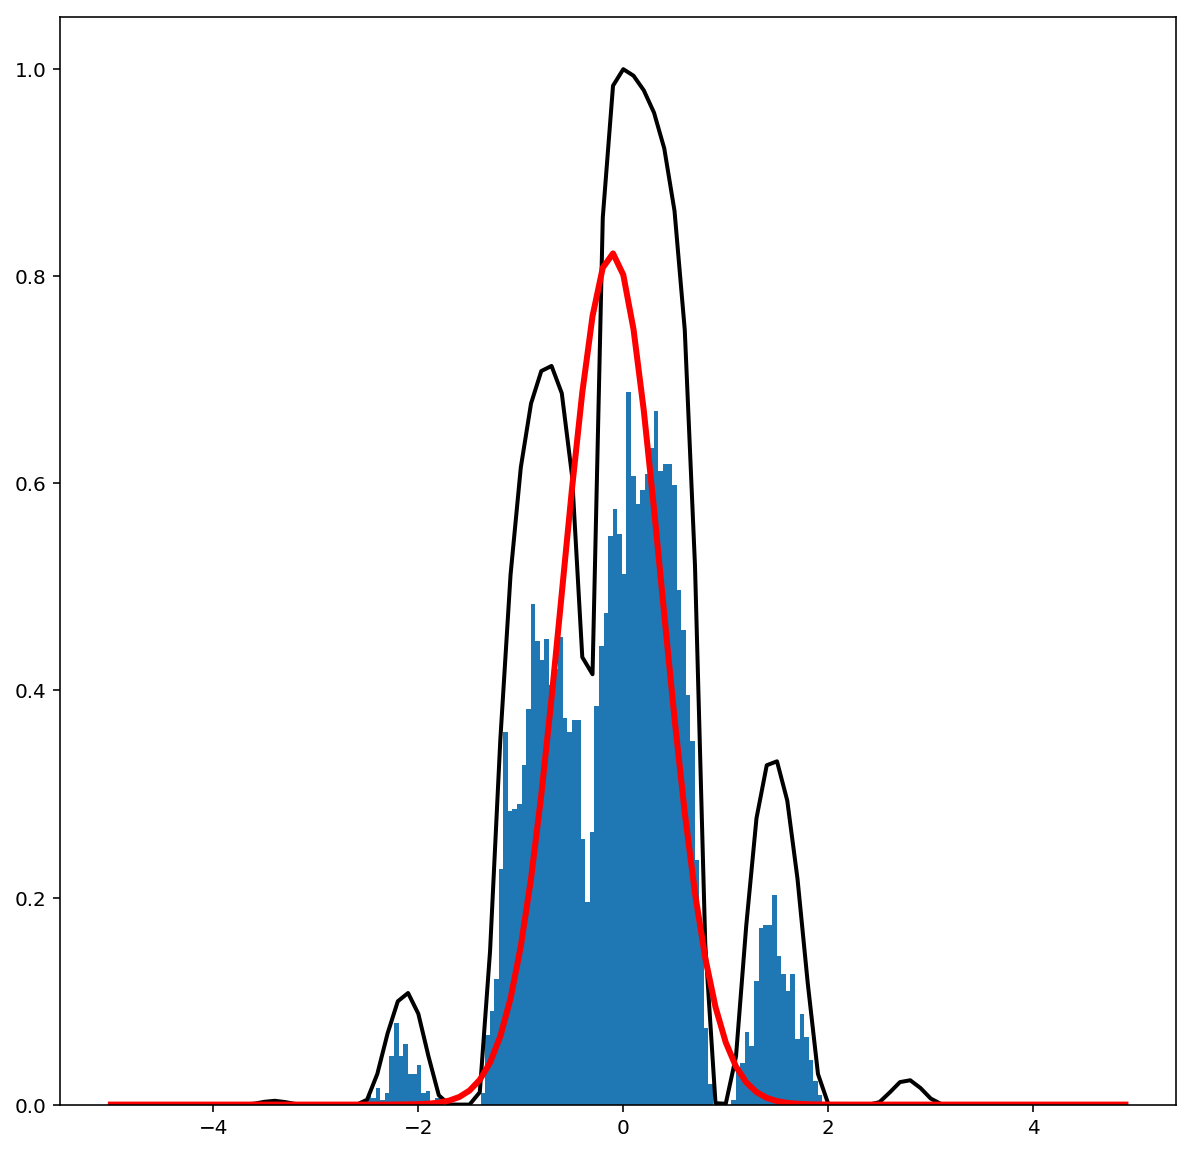

In [27]:
myhist = plt.hist(mcmc_sample, bins =100, normed = True)
t1 = np.arange(-5,5, 0.1)
h = plt.plot(t1, fn1(t1), lw=2, color = "k")
density = plt.plot(t1, norm.pdf(t1,mu[-1],math.sqrt(var[-1])), lw=3, color = "r")
plt.show()

In [51]:
mu[-1], var[-1]

(0.058981741988489593, 1.140255550039209)

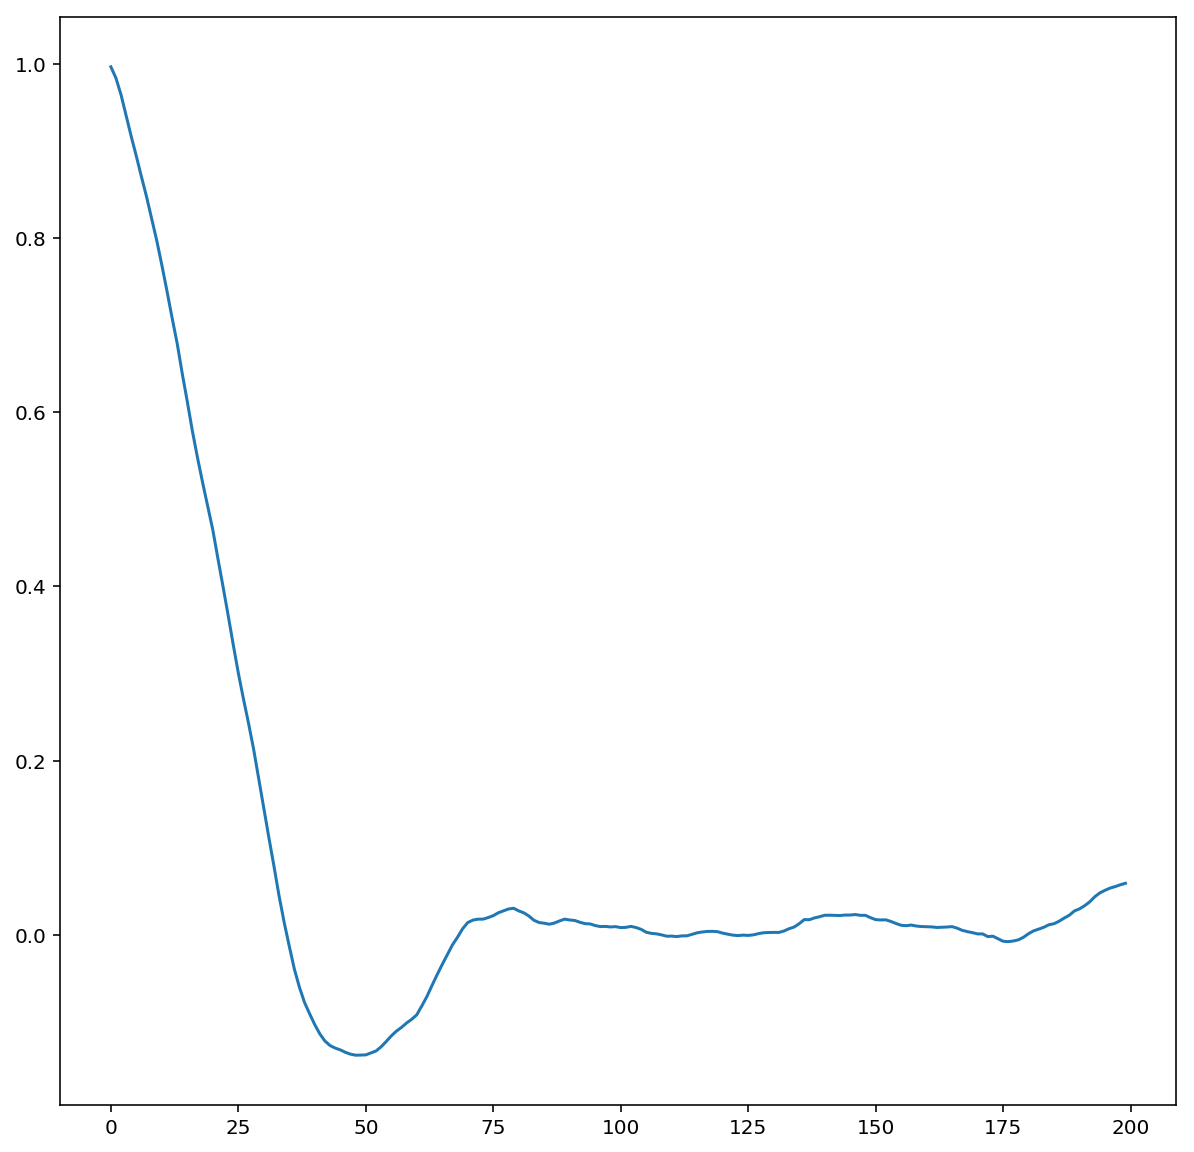

In [50]:
plt.plot(mu)

In [3]:
import numpy as np
import theano.tensor as T
import math


class Variational_Density_Estimation(object):

    def __init__(self, fn, mu_init, var_init, learning_rate, no_of_sample, no_of_epochs, momentum=.9):

        self.f = fn
        self.mu_init = mu_init
        self.var_init = var_init
        self.learning_rate = learning_rate
        self.n = no_of_sample
        self.epoch = no_of_epochs
        self.momentum = momentum

    def grad(self, mu, sigma):

        # w = T.vector('w')
        # x = T.scalar('x')
        # transformed_function = self.f(w[0] + w[1] * x)

        x = T.scalar('x')
        function_grad = T.grad(self.f(x), x)

        sample = np.random.randn(self.n)
        p_prime = np.array([function_grad.eval({x:mu+sigma*n}) for n in sample])

        p = np.array([self.f(mu + sigma * n) for n in sample])
        mu_grad = -np.mean(p_prime / p)
        sigma_grad = -1 / sigma - np.mean((p_prime / p) * sample)

        return mu_grad, sigma_grad

    def get_param(self):

        mu = self.mu_init
        s = math.sqrt(self.var_init)

        mu_arr = []
        var_arr = []

        mu_update = [0]
        s_update = [0]

        for i in range(self.epoch):

            update1 = self.momentum * mu_update[i] + (1 - self.momentum) * self.grad(mu, s)[0]
            update2 = self.momentum * mu_update[i] + (1 - self.momentum) * self.grad(mu, s)[1]

            mu = mu - self.learning_rate * update1
            s = s - self.learning_rate * update2

            mu_update.append(update1)
            s_update.append(update2)

            # mu = mu - self.learning_rate*self.grad(mu, s)[0]
            # s = s - self.learning_rate*self.grad(mu, s)[1]

            mu_arr.append(mu)
            var_arr.append(s ** 2)

            # We want to print the loss after every 5 epochs
            if i % 5 == 0:
                sum = 0
                for k in range(self.n):
                    sample = mu + s * np.random.randn()
                    sum = sum + np.log(self.f(sample))

                loss = -math.log(s) - sum / self.n
                print("Loss for epoch:{} is \t {:.4f}".format(i, loss))
        
        return mu_arr, var_arr

In [25]:
fn1 = lambda x: np.exp(-x ** 2 / (1.1 + np.sin(5*x)))
vi1 = Variational_Density_Estimation(fn1, 1, 2, .01, 1000, 400)
mu, var = vi1.get_param()

Loss for epoch:0 is 	 5.6570
Loss for epoch:5 is 	 6.2181
Loss for epoch:10 is 	 3.5028
Loss for epoch:15 is 	 2.4934
Loss for epoch:20 is 	 1.6585
Loss for epoch:25 is 	 1.3716
Loss for epoch:30 is 	 1.2849
Loss for epoch:35 is 	 1.2723
Loss for epoch:40 is 	 1.2931
Loss for epoch:45 is 	 1.3487
Loss for epoch:50 is 	 1.3771
Loss for epoch:55 is 	 1.3508
Loss for epoch:60 is 	 1.3536
Loss for epoch:65 is 	 1.2799
Loss for epoch:70 is 	 1.2594
Loss for epoch:75 is 	 1.2871
Loss for epoch:80 is 	 1.2437
Loss for epoch:85 is 	 1.2729
Loss for epoch:90 is 	 1.2794
Loss for epoch:95 is 	 1.2321
Loss for epoch:100 is 	 1.2261
Loss for epoch:105 is 	 1.2176
Loss for epoch:110 is 	 1.2504
Loss for epoch:115 is 	 1.2933
Loss for epoch:120 is 	 1.2337
Loss for epoch:125 is 	 1.2387
Loss for epoch:130 is 	 1.1991
Loss for epoch:135 is 	 1.2333
Loss for epoch:140 is 	 1.1966
Loss for epoch:145 is 	 1.1932
Loss for epoch:150 is 	 1.2451
Loss for epoch:155 is 	 1.2251
Loss for epoch:160 is 	 1.2543

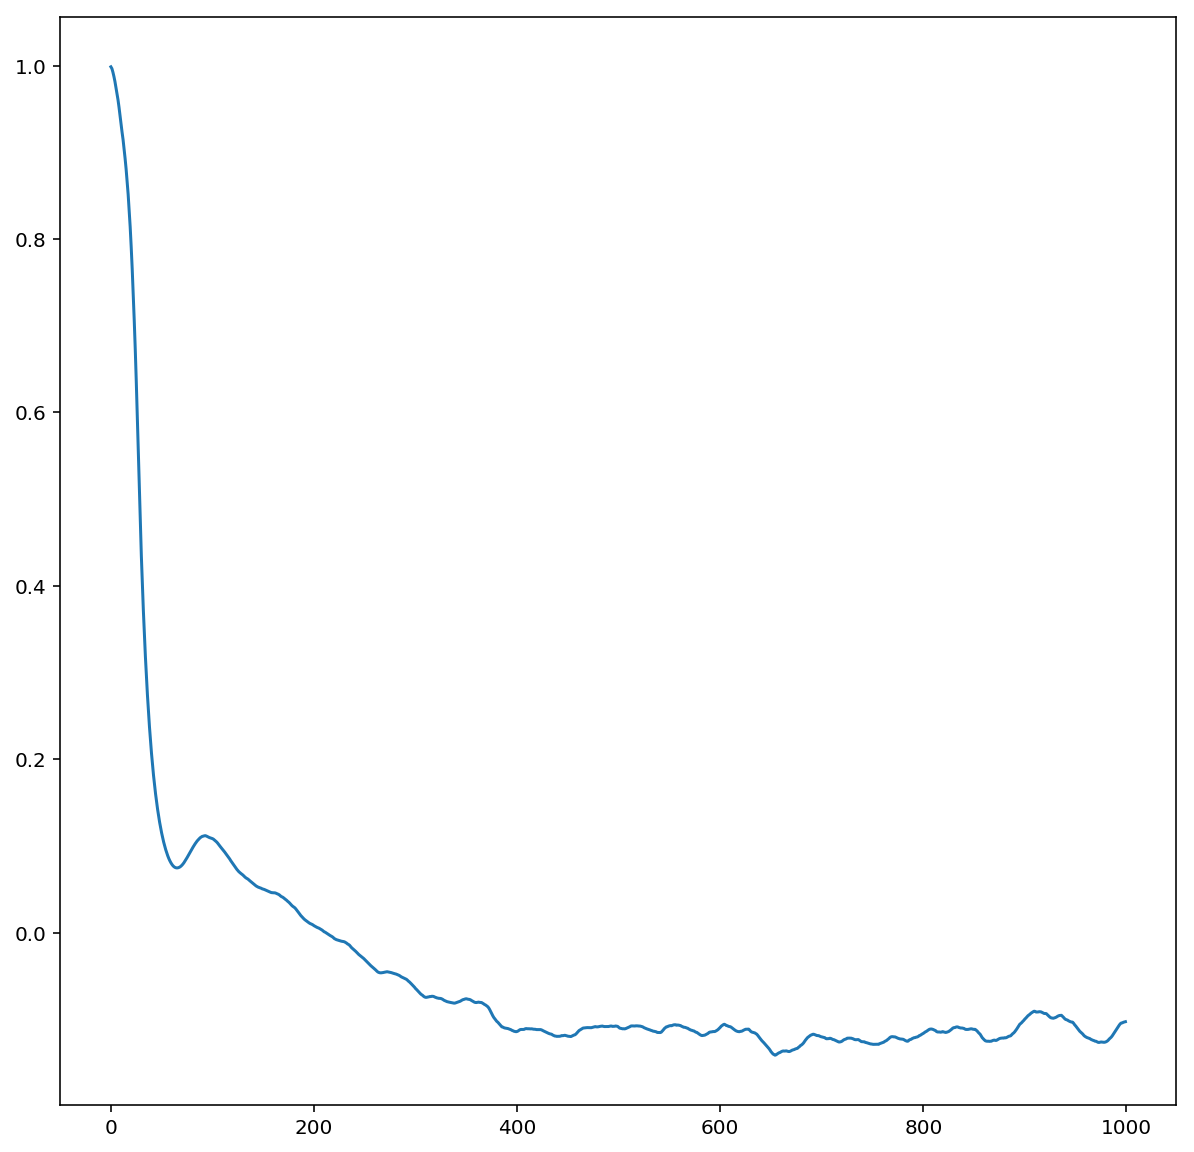

In [15]:
plt.plot(mu)
plt.show()

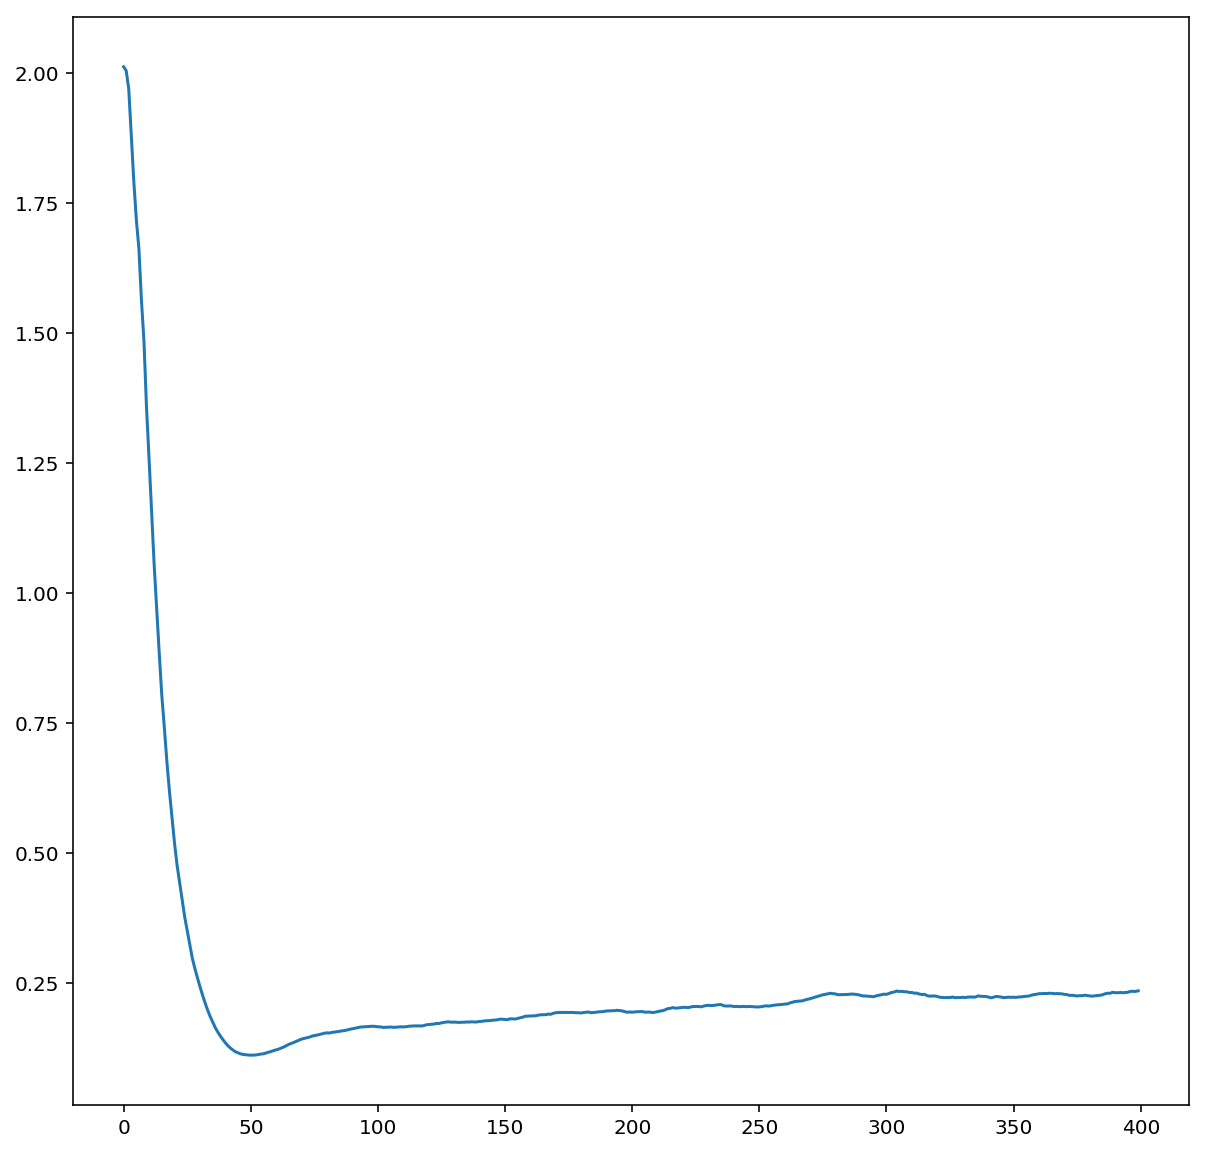

In [26]:
plt.plot(var)
plt.show()